In [10]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Function to load and preprocess images from a folder
def load_and_preprocess_images(folder_name, label, max_images=700, images=[], labels=[]):
    folder_path = os.path.join(os.getcwd(), folder_name)

    for i, file in enumerate(os.listdir(folder_path)):
        if i >= max_images:
            break
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Load image
            image_path = os.path.join(folder_path, file)
            image = Image.open(image_path)
            image_array = img_to_array(image)
            image_array = np.expand_dims(image_array, axis=0)
            image_array = preprocess_input(image_array)  # Preprocess the image
            
            images.append(image_array)
            labels.append(label)
    
    return labels, images


In [3]:
# Load and preprocess images from each folder
path = r"../database1/"
images=[]
labels=[]
labels, images = load_and_preprocess_images(path + 'output_farsi', 'farsi')
labels, images = load_and_preprocess_images(path + 'output_english', 'english', 700, images, labels)
labels, images = load_and_preprocess_images(path + 'output_arabic', 'arabic', 700, images, labels)
images = np.array(images).reshape(2100, 224, 224, 3)

In [9]:
# Load the pre-trained VGG16 model without the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new layers for your simple neural network
x = base_model.output
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
predictions = Dense(3, activation='softmax')(x)  # 3 classes

# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming 'images' is your array of images and 'labels' is your array of labels

# Convert string labels to integers
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

# Convert integer labels to one-hot encoding
labels_categorical = to_categorical(integer_encoded_labels, num_classes=3)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32 ,validation_data=(X_val, y_val)) 

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

# Predictions and confusion matrix
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(conf_matrix)

Epoch 1/10


46/46 [==============================] - 113s 2s/step - loss: 3.8080 - accuracy: 0.6558 - val_loss: 0.4707 - val_accuracy: 0.8032
Epoch 2/10
46/46 [==============================] - 118s 3s/step - loss: 0.5578 - accuracy: 0.7367 - val_loss: 0.2873 - val_accuracy: 0.8381
Epoch 3/10
46/46 [==============================] - 120s 3s/step - loss: 0.4850 - accuracy: 0.8000 - val_loss: 0.3630 - val_accuracy: 0.8698
Epoch 4/10
46/46 [==============================] - 117s 3s/step - loss: 0.4702 - accuracy: 0.7884 - val_loss: 0.3158 - val_accuracy: 0.8698
Epoch 5/10
46/46 [==============================] - 118s 3s/step - loss: 0.4293 - accuracy: 0.8231 - val_loss: 0.3132 - val_accuracy: 0.8952
Epoch 6/10
46/46 [==============================] - 117s 3s/step - loss: 0.3926 - accuracy: 0.8333 - val_loss: 0.3191 - val_accuracy: 0.8952
Epoch 7/10
46/46 [==============================] - 117s 3s/step - loss: 0.3860 - accuracy: 0.8259 - val_loss: 0.2288 - val_accuracy: 0.9238
Epoch 8/10


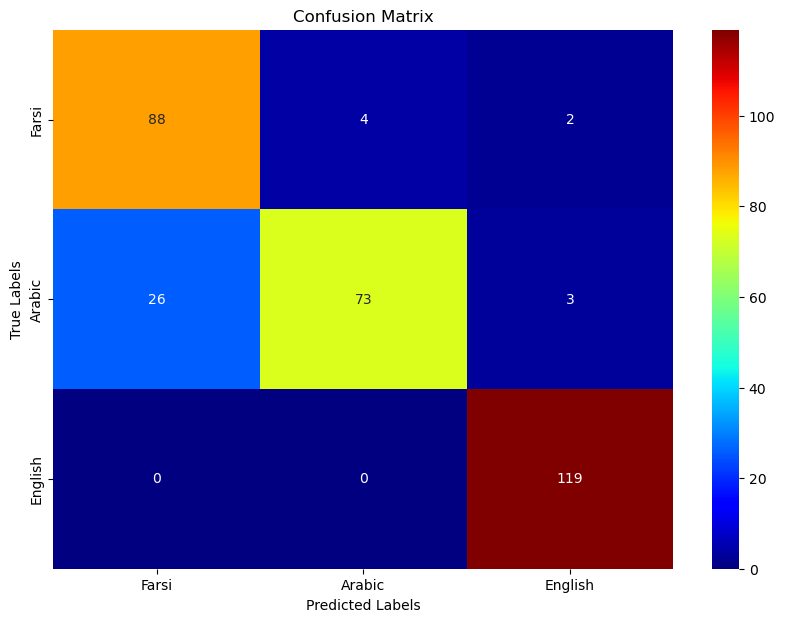

In [13]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Define class names
class_names = ['Farsi', 'Arabic', 'English']

# Plotting the confusion matrix with a colorbar
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='jet', cbar=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
